# Test dynamics

Yuri Shimane, 2022.10.27

In [1]:
using DifferentialEquations
using Plots
using LinearAlgebra

In [2]:
include("../../julia-r3bp/R3BP/src/R3BP.jl")

Main.R3BP

In [3]:
include("../src/SailorMoon.jl")   # relative path to main file of module

Main.SailorMoon

### Create final state

In [12]:
param3b = SailorMoon.dyanmics_parameters()
param3b_nosun = SailorMoon.dyanmics_parameters(false)

Main.SailorMoon.dynamics_params(0.987849414390376, 0.01215058560962404, 0.0, 384748.32292972936, 375700.3437894195, 1.0, -0.9251999994040079, 0.9251999994040079, 0.01709689063726318, 7.601281331451572)

In [5]:
lp = 2
Az_km = 28000.0
println("Halo guess Az_km: $Az_km")
northsouth = 3   # 1 or 3
guess0 = R3BP.halo_analytical_construct(param3b.mu2, lp, Az_km, param3b.lstar, northsouth)
res = R3BP.ssdc_periodic_xzplane([param3b.mu2,], guess0.x0, guess0.period, fix="z")
res.flag

Halo guess Az_km: 28000.0


1

In [6]:
x0_stm = vcat(res.x0, reshape(I(6), (6^2,)))[:]
prob_cr3bp_stm = ODEProblem(R3BP.rhs_cr3bp_svstm!, x0_stm, res.period, (param3b.mu2))
sol = solve(prob_cr3bp_stm, Tsit5(), reltol=1e-12, abstol=1e-12)#, saveat=LinRange(0, period, n+1))
monodromy = R3BP.get_stm(sol, 6)   # get monodromy matrix
ys0 = R3BP.get_eigenvector(monodromy, true, 1)

Linear stability ν = 290.9383214356218


6-element Vector{Float64}:
 -0.1954811166094517
 -0.29399446049543554
  0.060738148589877576
  0.6067152007112099
  0.4667342148543378
 -0.534528863077809

In [54]:
# arrival LPO object
LPOArrival = SailorMoon.CR3BPLPO(
    res.x0, res.period, ys0, prob_cr3bp_stm, -1e-6, Tsit5(), 1e-12, 1e-12
);

In [56]:
# ϕ = 0.5
# θm = deg2rad(210)

# sv_end = SailorMoon.set_terminal_state(ϕ, θm, param3b, LPOArrival)

In [53]:
ϕ = 0.5
θm = deg2rad(210)

sv_end = SailorMoon.set_terminal_state(ϕ, θm, param3b, LPOArrival)

6-element Vector{Float64}:
 -1.0123695062569602
 -0.5844916658523779
  0.09812983722130537
  0.44343209920301835
 -0.7680485739300638
  0.0981301728155214

In [40]:
thetas = LinRange(0, 2π, 100)
xs_earth_circle = [-param3b.mu2*cos(theta) for theta in thetas];
ys_earth_circle = [-param3b.mu2*sin(theta) for theta in thetas];
xs_moon_circle = [(1-param3b.mu2)*cos(theta) for theta in thetas];
ys_moon_circle = [(1-param3b.mu2)*sin(theta) for theta in thetas];

In [41]:
lps = SailorMoon.lagrange_points(param3b.mu2)
lps_sb1 = zeros(5,6)
for i = 1:5
    lps_sb1[i,:] = SailorMoon.transform_EMrot_to_SunB1(lps[i,:], π-θm, param3b.oms)
end

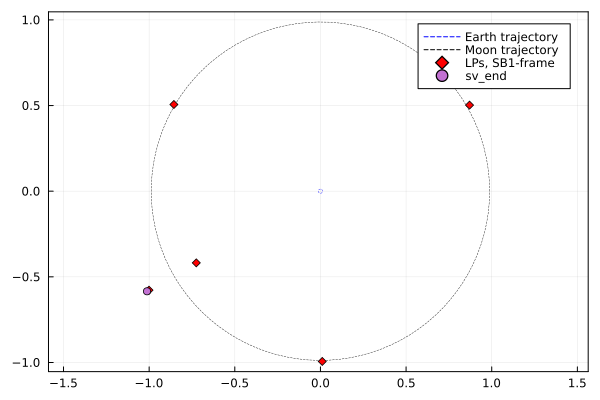

In [42]:
pcart = plot(size=(600,400), frame_style=:box, aspect_ratio=:equal)

plot!(pcart, xs_earth_circle, ys_earth_circle, 
    color=:blue, linestyle=:dash, label="Earth trajectory", linewidth=0.4)
plot!(pcart, xs_moon_circle, ys_moon_circle, 
    color=:black, linestyle=:dash, label="Moon trajectory", linewidth=0.4)
scatter!(pcart, lps_sb1[:,1], lps_sb1[:,2], marker=:diamond, color=:red, label="LPs, SB1-frame")
scatter!(pcart, [sv_end[1]], [sv_end[2]], label="sv_end")

pcart

In [43]:
rad2deg(θm)

210.00000000000003

In [57]:
mdot = 0.0
tmax = 0.0
τ, γ, β = 0.0, 0.0, 0.0
θ0 = 1.0*θm
tspan = [0.0, -15.0]

2-element Vector{Float64}:
   0.0
 -15.0

In [58]:
params = [param3b.mu2, param3b.mus, param3b.as, θ0, param3b.oml, τ, γ, β, mdot, tmax]
ode_prob = ODEProblem(SailorMoon.rhs_bcr4bp_with_mass!, vcat(sv_end,1), tspan, params)
sol = solve(ode_prob, Tsit5(), reltol=1e-12, abstol=1e-12);
sol.retcode

:Success

In [59]:
params = [param3b.mu2, 0.0, param3b.as, θ0, param3b.oml, τ, γ, β, mdot, tmax]
ode_prob = ODEProblem(SailorMoon.rhs_bcr4bp_with_mass!, vcat(sv_end,1), tspan, params)
sol_nosun = solve(ode_prob, Tsit5(), reltol=1e-12, abstol=1e-12);
sol_nosun.retcode

:Success

In [60]:
Array(sol)

7×1315 Matrix{Float64}:
 -1.01237    -1.013      -1.014      -1.01517    …  -15.8176     -15.715
 -0.584492   -0.583413   -0.581715   -0.579781      -26.7454     -26.8098
  0.09813     0.0979918   0.097773    0.0975219      -1.562       -1.56224
  0.443434    0.448883    0.45747     0.467272      -26.9761     -27.0381
 -0.768048   -0.766646   -0.764405   -0.7618         17.012       16.908
  0.0981296   0.098404    0.0988362   0.0993293  …    0.0646234    0.0645939
  1.0         1.0         1.0         1.0             1.0          1.0

In [62]:
plotly()

┌ Warning: For saving to png with the `Plotly` backend `PlotlyBase` and `PlotlyKaleido` need to be installed.
│   err = ArgumentError("Package PlotlyKaleido not found in current path:\n- Run `import Pkg; Pkg.add(\"PlotlyKaleido\")` to install the PlotlyKaleido package.\n")
└ @ Plots C:\Users\yshimane3\.julia\packages\Plots\fw4rv\src\backends.jl:426


Plots.PlotlyBackend()

In [63]:
pcart = plot(size=(700,500), frame_style=:box, aspect_ratio=:equal)

plot!(pcart, xs_earth_circle, ys_earth_circle, 
    color=:blue, linestyle=:dash, label="Earth trajectory", linewidth=0.4)
plot!(pcart, xs_moon_circle, ys_moon_circle, 
    color=:black, linestyle=:dash, label="Moon trajectory", linewidth=0.4)
scatter!(pcart, lps_sb1[:,1], lps_sb1[:,2], marker=:diamond, color=:red, label="LPs, SB1-frame")
scatter!(pcart, [sv_end[1]], [sv_end[2]], label="sv_end")

# trajectory
plot!(Array(sol)[1,:], Array(sol)[2,:], color=:purple, linewidth=1.5, label="bcr4bp")
plot!(Array(sol_nosun)[1,:], Array(sol_nosun)[2,:], color=:blue, linewidth=1.5, label="cr3bp")

pcart